Episode 0/5000
Episode 100/5000
Episode 200/5000
Episode 300/5000
Episode 400/5000
Episode 500/5000
Episode 600/5000
Episode 700/5000
Episode 800/5000
Episode 900/5000
Episode 1000/5000
Episode 1100/5000
Episode 1200/5000
Episode 1300/5000
Episode 1400/5000
Episode 1500/5000
Episode 1600/5000
Episode 1700/5000
Episode 1800/5000
Episode 1900/5000
Episode 2000/5000
Episode 2100/5000
Episode 2200/5000
Episode 2300/5000
Episode 2400/5000
Episode 2500/5000
Episode 2600/5000
Episode 2700/5000
Episode 2800/5000
Episode 2900/5000
Episode 3000/5000
Episode 3100/5000
Episode 3200/5000
Episode 3300/5000
Episode 3400/5000
Episode 3500/5000
Episode 3600/5000
Episode 3700/5000
Episode 3800/5000
Episode 3900/5000
Episode 4000/5000
Episode 4100/5000
Episode 4200/5000
Episode 4300/5000
Episode 4400/5000
Episode 4500/5000
Episode 4600/5000
Episode 4700/5000
Episode 4800/5000
Episode 4900/5000
Avg Reward: 135.60
Success Rate: 93.28%
Robot 1: [[9, 7], [8, 7], [7, 7], [7, 6], [7, 5], [6, 5], [5, 5], [5, 6]

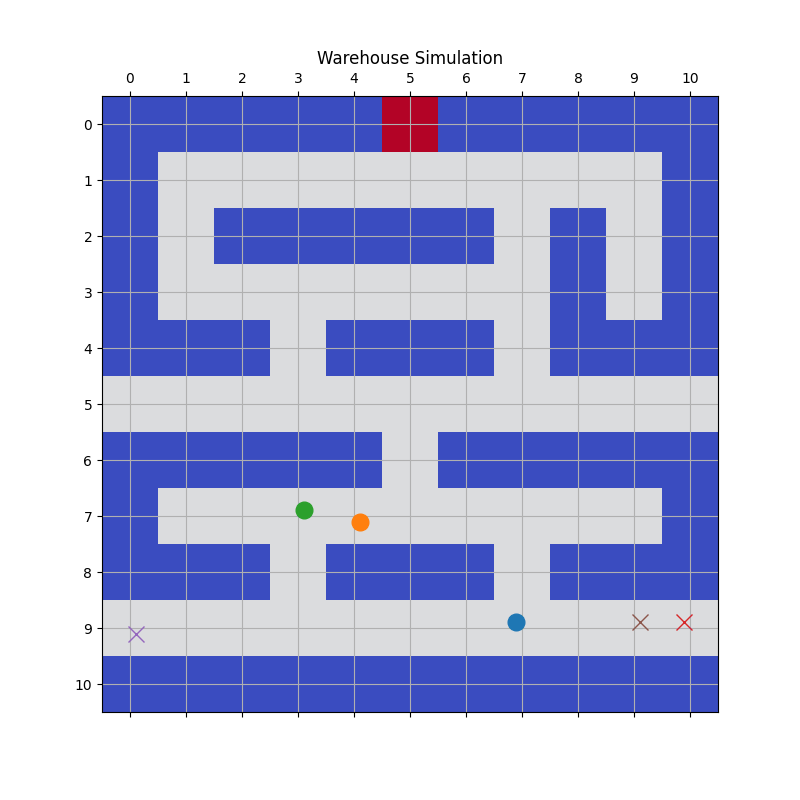

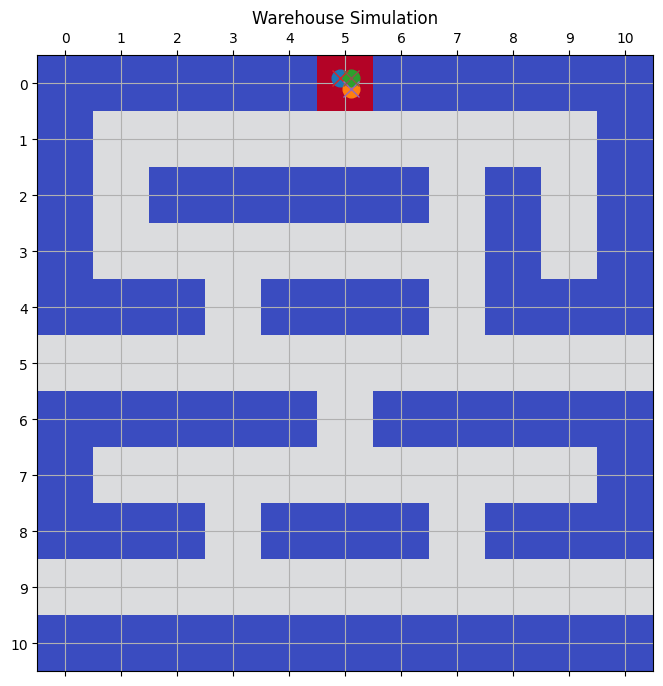

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display


# Grid setup
num_rows, num_columns = 11, 11
actions = ['up', 'right', 'down', 'left']
penalties = np.full((num_rows, num_columns), -100.0)
penalties[0, 5] = 100.0  # Goal

open_areas = {
    1: list(range(1, 10)), 2: [1, 7, 9], 3: list(range(1, 8)) + [9],
    4: [3, 7], 5: list(range(num_columns)), 6: [5],
    7: list(range(1, 10)), 8: [3, 7], 9: list(range(num_columns))
}
for row in range(1, 10):
    for col in open_areas[row]:
        penalties[row, col] = -1.0

def check_terminal_state(row, col):
    return penalties[row, col] in [100.0, -100.0]

valid_positions = [(r, c) for r in range(num_rows) for c in range(num_columns) if not check_terminal_state(r, c)]

def random_start():
    return valid_positions[np.random.randint(len(valid_positions))]

def calculate_distance_to_goal(row, col, goal_row=0, goal_col=5):
    return abs(row - goal_row) + abs(col - goal_col)

def farthest_start(goal_row=0, goal_col=5):
    distances = [(calculate_distance_to_goal(r, c, goal_row, goal_col), (r, c)) for r, c in valid_positions]
    distances.sort(reverse=True)
    return distances[0][1], distances[1][1], distances[2][1]

def select_action(row, col, epsilon, q_values):
    if np.random.random() < epsilon:
        return np.random.randint(4)
    best_actions = np.where(q_values[row, col] == np.max(q_values[row, col]))[0]
    return np.random.choice(best_actions)

def calculate_next_position(row, col, action):
    if actions[action] == 'up' and row > 0:
        row -= 1
    elif actions[action] == 'right' and col < num_columns - 1:
        col += 1
    elif actions[action] == 'down' and row < num_rows - 1:
        row += 1
    elif actions[action] == 'left' and col > 0:
        col -= 1
    return row, col

def train_q_learning(episodes, epsilon=1.0, gamma=0.9, alpha=0.9):
    robot_q = np.zeros((num_rows, num_columns, 4))
    human_q = np.zeros((num_rows, num_columns, 4))
    total_rewards = []
    success_count = 0

    for ep in range(episodes):
        ep_reward = 0
        reached_goal = False

        # Robot training
        row, col = random_start()
        for _ in range(1000):
            if check_terminal_state(row, col): break
            action = select_action(row, col, epsilon, robot_q)
            new_row, new_col = calculate_next_position(row, col, action)
            reward = penalties[new_row, new_col]
            ep_reward += reward
            td = reward + gamma * np.max(robot_q[new_row, new_col]) - robot_q[row, col, action]
            robot_q[row, col, action] += alpha * td
            row, col = new_row, new_col
            if (row, col) == (0, 5): reached_goal = True; break

        # Human training
        row, col = random_start()
        for _ in range(1000):
            if check_terminal_state(row, col): break
            action = select_action(row, col, epsilon, human_q)
            new_row, new_col = calculate_next_position(row, col, action)
            reward = penalties[new_row, new_col]
            ep_reward += reward
            td = reward + gamma * np.max(human_q[new_row, new_col]) - human_q[row, col, action]
            human_q[row, col, action] += alpha * td
            row, col = new_row, new_col
            if (row, col) == (0, 5): reached_goal = True; break

        total_rewards.append(ep_reward)
        if reached_goal: success_count += 1
        epsilon = max(0.01, epsilon * 0.995)

        if ep % 100 == 0:
            print(f"Episode {ep}/{episodes}")

    print(f"Avg Reward: {np.mean(total_rewards):.2f}")
    print(f"Success Rate: {100 * success_count / episodes:.2f}%")
    return robot_q, human_q, total_rewards


def find_shortest_path(start_row, start_col, q_values, max_steps=200):
    path = [[start_row, start_col]]
    visited = set()
    row, col = start_row, start_col

    for _ in range(max_steps):
        if check_terminal_state(row, col) or (row, col) in visited:
            break
        visited.add((row, col))
        action = select_action(row, col, epsilon=0, q_values=q_values)
        row, col = calculate_next_position(row, col, action)
        path.append([row, col])
    return path, len(path)

def simulate_paths(robot_starts, human_starts, robot_q, human_q):
    robot_paths = [find_shortest_path(r[0], r[1], robot_q) for r in robot_starts]
    human_paths = [find_shortest_path(h[0], h[1], human_q) for h in human_starts]

    for i, path in enumerate(robot_paths):
        print(f"Robot {i+1}: {path[0]} | Steps: {path[1]}")
    for i, path in enumerate(human_paths):
        print(f"Human {i+1}: {path[0]} | Steps: {path[1]}")
    return robot_paths, human_paths

def create_simulation_gif(robot_paths, human_paths, output_file="warehouse_simulation.gif"):
    fig, ax = plt.subplots(figsize=(8, 8))
    grid_display = penalties.copy()
    offsets = [(-0.1, -0.1), (0.1, 0.1), (-0.1, 0.1)]
    labels_added = False

    def plot_grid():
        ax.matshow(grid_display, cmap="coolwarm", vmin=-100, vmax=100)
        ax.set_xticks(np.arange(num_columns))
        ax.set_yticks(np.arange(num_rows))
        ax.grid(True)
        ax.set_title("Warehouse Simulation")

    def update(frame):
        nonlocal labels_added
        ax.clear()
        plot_grid()
        for i, path in enumerate(robot_paths):
            r, c = path[0][frame] if frame < len(path[0]) else path[0][-1]
            offset = offsets[i % len(offsets)]
            ax.plot(c + offset[1], r + offset[0], 'o', color=f"C{i}", markersize=12, label=f"Robot {i+1}" if frame == 0 else "")
        for i, path in enumerate(human_paths):
            r, c = path[0][frame] if frame < len(path[0]) else path[0][-1]
            offset = offsets[i % len(offsets)]
            ax.plot(c + offset[1], r + offset[0], 'x', color=f"C{i+3}", markersize=12, label=f"Human {i+1}" if frame == 0 else "")
        if not labels_added:
            ax.legend(loc="upper right")
            labels_added = True

    total_frames = max(len(p[0]) for p in robot_paths + human_paths)
    ani = FuncAnimation(fig, update, frames=total_frames, interval=500)
    ani.save(output_file, writer=PillowWriter(fps=5))
    print(f"Simulation saved as {output_file}")
    display(Image(filename=output_file))


# Run everything
if __name__ == "__main__":
    robot_q, human_q, total_rewards = train_q_learning(episodes=5000, epsilon=1.0, gamma=0.95, alpha=0.8)
    robot_starts = [(9, 7), (7, 4), (7, 3)]
    human_starts = list(farthest_start())
    robot_paths, human_paths = simulate_paths(robot_starts, human_starts, robot_q, human_q)
    create_simulation_gif(robot_paths, human_paths)


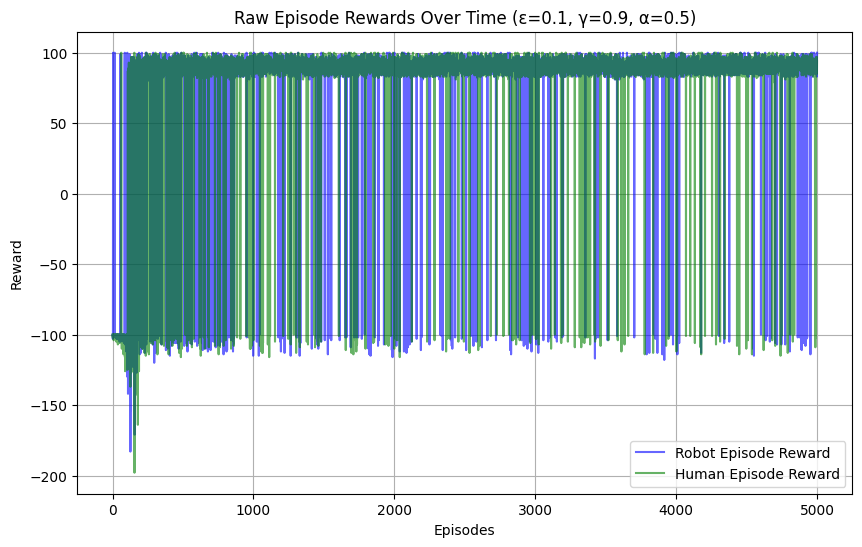

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# --- Environment Setup ---
num_rows, num_columns = 11, 11
actions = ['up', 'right', 'down', 'left']
penalties = np.full((num_rows, num_columns), -100.0)
penalties[0, 5] = 100.0  # Goal

open_areas = {
    1: list(range(1, 10)), 2: [1, 7, 9], 3: list(range(1, 8)) + [9],
    4: [3, 7], 5: list(range(num_columns)), 6: [5],
    7: list(range(1, 10)), 8: [3, 7], 9: list(range(num_columns))
}
for row in range(1, 10):
    for col in open_areas[row]:
        penalties[row, col] = -1.0

# --- Helper Functions ---
def check_terminal_state(row, col):
    return penalties[row, col] in [100.0, -100.0]

def random_start():
    while True:
        row, col = np.random.randint(num_rows), np.random.randint(num_columns)
        if not check_terminal_state(row, col):
            return row, col

def select_action(row, col, epsilon, q_values):
    if np.random.random() < epsilon:
        return np.random.randint(4)
    return np.argmax(q_values[row, col])

def calculate_next_position(row, col, action):
    if actions[action] == 'up' and row > 0:
        row -= 1
    elif actions[action] == 'right' and col < num_columns - 1:
        col += 1
    elif actions[action] == 'down' and row < num_rows - 1:
        row += 1
    elif actions[action] == 'left' and col > 0:
        col -= 1
    return row, col

# --- Q-Learning Training ---
def train_q_learning(episodes=5000, epsilon=0.1, gamma=0.9, alpha=0.5):
    robot_q_values = np.zeros((num_rows, num_columns, 4))
    human_q_values = np.zeros((num_rows, num_columns, 4))
    robot_rewards = []
    human_rewards = []

    for episode in range(episodes):
        # Robot agent
        row, col = random_start()
        robot_total_reward = 0
        while not check_terminal_state(row, col):
            action = select_action(row, col, epsilon, robot_q_values)
            new_row, new_col = calculate_next_position(row, col, action)
            reward = penalties[new_row, new_col]
            td_error = reward + gamma * np.max(robot_q_values[new_row, new_col]) - robot_q_values[row, col, action]
            robot_q_values[row, col, action] += alpha * td_error
            robot_total_reward += reward
            row, col = new_row, new_col
        robot_rewards.append(robot_total_reward)

        # Human agent
        row, col = random_start()
        human_total_reward = 0
        while not check_terminal_state(row, col):
            action = select_action(row, col, epsilon, human_q_values)
            new_row, new_col = calculate_next_position(row, col, action)
            reward = penalties[new_row, new_col]
            td_error = reward + gamma * np.max(human_q_values[new_row, new_col]) - human_q_values[row, col, action]
            human_q_values[row, col, action] += alpha * td_error
            human_total_reward += reward
            row, col = new_row, new_col
        human_rewards.append(human_total_reward)

        epsilon = max(0.01, epsilon * 0.998)  # Slower decay for smoother learning

    return robot_rewards, human_rewards, robot_q_values, human_q_values

def plot_rewards(robot_rewards, human_rewards):
    # Oscillated reward plot (raw only)
    plt.figure(figsize=(10, 6))
    plt.plot(robot_rewards, label="Robot Episode Reward", color='blue', alpha=0.6)
    plt.plot(human_rewards, label="Human Episode Reward", color='green', alpha=0.6)
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Raw Episode Rewards Over Time (ε=0.1, γ=0.9, α=0.5)")
    plt.grid(True)
    plt.legend()
    plt.show()

   
# --- Run Training and Plot ---
robot_rewards, human_rewards, robot_q_values, human_q_values = train_q_learning()
plot_rewards(robot_rewards, human_rewards)


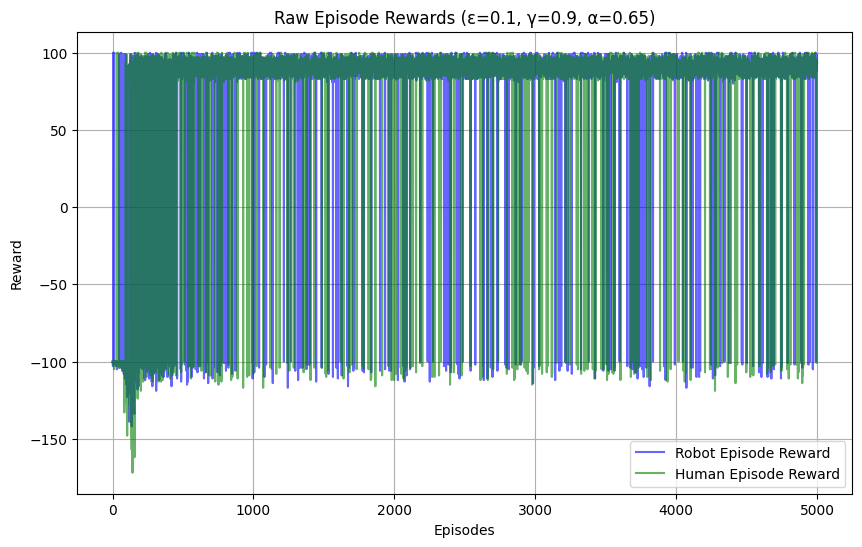

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# --- Environment Setup ---
num_rows, num_columns = 11, 11
actions = ['up', 'right', 'down', 'left']
penalties = np.full((num_rows, num_columns), -100.0)
penalties[0, 5] = 100.0  # Goal

open_areas = {
    1: list(range(1, 10)), 2: [1, 7, 9], 3: list(range(1, 8)) + [9],
    4: [3, 7], 5: list(range(num_columns)), 6: [5],
    7: list(range(1, 10)), 8: [3, 7], 9: list(range(num_columns))
}
for row in range(1, 10):
    for col in open_areas[row]:
        penalties[row, col] = -1.0

# --- Helper Functions ---
def check_terminal_state(row, col):
    return penalties[row, col] in [100.0, -100.0]

def random_start():
    while True:
        row, col = np.random.randint(num_rows), np.random.randint(num_columns)
        if not check_terminal_state(row, col):
            return row, col

def select_action(row, col, epsilon, q_values):
    if np.random.random() < epsilon:
        return np.random.randint(4)
    return np.argmax(q_values[row, col])

def calculate_next_position(row, col, action):
    if actions[action] == 'up' and row > 0:
        row -= 1
    elif actions[action] == 'right' and col < num_columns - 1:
        col += 1
    elif actions[action] == 'down' and row < num_rows - 1:
        row += 1
    elif actions[action] == 'left' and col > 0:
        col -= 1
    return row, col

# --- Q-Learning Training ---
def train_q_learning(episodes=5000, epsilon=0.1, gamma=0.9, alpha=0.65):
    robot_q_values = np.zeros((num_rows, num_columns, 4))
    human_q_values = np.zeros((num_rows, num_columns, 4))
    robot_rewards = []
    human_rewards = []

    for episode in range(episodes):
        # Robot agent
        row, col = random_start()
        robot_total_reward = 0
        while not check_terminal_state(row, col):
            action = select_action(row, col, epsilon, robot_q_values)
            new_row, new_col = calculate_next_position(row, col, action)
            reward = penalties[new_row, new_col]
            td_error = reward + gamma * np.max(robot_q_values[new_row, new_col]) - robot_q_values[row, col, action]
            robot_q_values[row, col, action] += alpha * td_error
            robot_total_reward += reward
            row, col = new_row, new_col
        robot_rewards.append(robot_total_reward)

        # Human agent
        row, col = random_start()
        human_total_reward = 0
        while not check_terminal_state(row, col):
            action = select_action(row, col, epsilon, human_q_values)
            new_row, new_col = calculate_next_position(row, col, action)
            reward = penalties[new_row, new_col]
            td_error = reward + gamma * np.max(human_q_values[new_row, new_col]) - human_q_values[row, col, action]
            human_q_values[row, col, action] += alpha * td_error
            human_total_reward += reward
            row, col = new_row, new_col
        human_rewards.append(human_total_reward)

        epsilon = max(0.01, epsilon * 0.998)

    return robot_rewards, human_rewards, robot_q_values, human_q_values

# --- Plotting ---
def plot_raw_rewards(robot_rewards, human_rewards):
    # Raw episode reward plot
    plt.figure(figsize=(10, 6))
    plt.plot(robot_rewards, label="Robot Episode Reward", color='blue', alpha=0.6)
    plt.plot(human_rewards, label="Human Episode Reward", color='green', alpha=0.6)
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.title("Raw Episode Rewards (ε=0.1, γ=0.9, α=0.65)")
    plt.grid(True)
    plt.legend()
    plt.show()

    
# --- Run Training and Plot ---
robot_rewards, human_rewards, robot_q_values, human_q_values = train_q_learning()
plot_raw_rewards(robot_rewards, human_rewards)
